# Programming for Data Science and Artificial Intelligence

## 9.21 Deep Learning - PyTorch - Audio Processing Part 2

Paper - https://arxiv.org/abs/1610.00087

### Speech Command Recognition

Here we will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

#mac/linux
torchaudio.set_audio_backend("sox_io")

/Users/chaklam/DSAI/Environments/teaching_env/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


Let’s check if a CUDA GPU is available and select our device. Running the network on a GPU will greatly decrease the training/testing runtime.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files to tensors. If one wants to load an audio file directly instead, ``torchaudio.load()`` can be used. It returns a tuple containing the newly created tensor along with the sampling frequency of the audio file (16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into standard training, validation, testing subsets.

In [3]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("data/", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform (the audio signal), the sample rate, the utterance (label), the ID of the speaker, the number of the utterance.

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


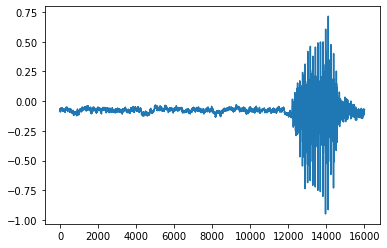

In [4]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.

In [5]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few files are people saying “marvin”.

In [6]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

In [7]:
waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

### Formatting the Data

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing too much of the classification power.

We don’t need to apply other transformations here. It is common for some datasets though to have to reduce the number of channels (say from stereo to mono)  by either taking the mean along the channel dimension, or simply keeping only one of the channels. Since SpeechCommands uses a single channel for audio, this is not needed here.

In [9]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.

In [10]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances into two batched tensors for the model, we implement a collate function which is used by the PyTorch DataLoader that allows us to iterate over a dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.

In [11]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

### Define the Network

For this tutorial we will use a convolutional neural network to process the raw audio data. Usually more advanced transforms are applied to the audio data, however CNNs can be used to accurately process the raw data. The specific architecture is modeled after the M5 network architecture described in https://arxiv.org/pdf/1610.00087.pdf. An important aspect
of models processing raw audio data is the receptive field of their
first layer’s filters. Our model’s first filter is length 80 so when processing audio sampled at 8kHz the receptive field is around 10ms. This size is similar to speech processing applications that often use receptive fields ranging from 20ms to 40ms.

In [12]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam optimizer with weight decay set to 0.0001. At first, we will train with a learning rate of 0.01, but we will use a ``scheduler`` to decrease it to 0.001 during training.

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

### Training and Testing the Network

Now let’s define a training function that will feed our training data into the model and perform the backward pass and optimization steps. For training, the loss we will use is the negative log-likelihood. The network will then be tested after each epoch to see how the accuracy varies during the training.

In [14]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing the networks accuracy. We will set the model to ``eval()`` mode and then run inference on the test dataset. Calling ``eval()`` sets the training variable in all modules in the network to false. Certain layers like batch normalization and dropout layers behave differently during training so this step is crucial for getting correct results.

In [15]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network for ten epochs then reduce the learn rate and train for ten more epochs. The network will be tested after each epoch to see how the accuracy varies during the training.

In [16]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.936203
Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.051607
Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.431350
Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.249959
Train Epoch: 1 [20480/84843 (24%)]	Loss: 1.990671
Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.919318
Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.778208
Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.750106
Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.693388
Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.452483
Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.435632
Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.407968
Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.382142
Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.163282
Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.295292
Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.305523
Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.040641

Test Epoch: 1	Accuracy: 3445/11005 (31%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.150088
Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.158540
Train Epoch: 2 [10240

The network should be more than 65% accurate on the test set after 2 epochs, and 85% after 21 epochs. Let’s look at the last words in the train set, and see how the model did on it.

In [17]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.

In [18]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #1. Expected: right. Predicted: learn.


### Exercise

- Try RNNs instead
- Try Mel Frequency Cepstral Coefficients that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.